A Survey on Technology Choice
======


In [1]:
library(MASS)
library(dplyr)
library(tidyr)
library(caret)
library(datasets)


Attaching package: 'dplyr'

The following object is masked from 'package:MASS':

    select

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Loading required package: lattice
Loading required package: ggplot2


In [2]:
# For nicer printing
options(digits=2);

In [3]:
# Read in the data
data <- read.csv("TechSurvey - Survey.csv",header=T);

#convert date to unix second
for (i in c("Start", "End")) 
    data[,i] = as.numeric(as.POSIXct(strptime(data[,i], "%Y-%m-%d %H:%M:%S")))
for (i in 0:12){
    vnam = paste(c("PG",i,"Submit"), collapse="")
    data[,vnam] = as.numeric(as.POSIXct(strptime(data[,vnam], "%Y-%m-%d %H:%M:%S")))
}
#calculate differences in time    
for (i in 12:0){
    pv = paste(c("PG",i-1,"Submit"), collapse="");
    if (i==0) 
        pv="Start";
    vnam = paste(c("PG",i,"Submit"), collapse="");
    data[,vnam] = data[,vnam] -data[,pv];
}

In [4]:
#now explore variables
summary(data);

     Device    Completed       Start               End               PG0Dis   
        :  2   0    :  2   Min.   :1.54e+09   Min.   :1.54e+09   Min.   :  0  
 Bot    :  1   FALSE:546   1st Qu.:1.54e+09   1st Qu.:1.54e+09   1st Qu.:  0  
 PC     :955   TRUE :805   Median :1.54e+09   Median :1.54e+09   Median :  1  
 Phone  :376               Mean   :1.54e+09   Mean   :1.54e+09   Mean   : 44  
 Tablet : 16               3rd Qu.:1.54e+09   3rd Qu.:1.54e+09   3rd Qu.: 24  
 Unknown:  3               Max.   :1.54e+09   Max.   :1.54e+09   Max.   :168  
                           NA's   :2          NA's   :548        NA's   :73   
    PG0Shown      PG0Submit    
 Min.   :   0   Min.   :    2  
 1st Qu.:   0   1st Qu.:    6  
 Median : 102   Median :    9  
 Mean   : 249   Mean   :  299  
 3rd Qu.: 428   3rd Qu.:   15  
 Max.   :1190   Max.   :76226  
 NA's   :73     NA's   :199    
                                       PG1PsnUse  
 For personal work and/or research use      :727  
          

### Interpret  basic summaries

In [5]:
#get numeric fields only for correlation
sel = c()
for (i in 1:dim(data)[2]) if (is.numeric(data[,i])) sel = c(sel, i);


cor(data[,sel],method="spearman",use="pairwise.complete.obs"); #OK for any: uses ranks

,Start,End,PG0Dis,PG0Shown,PG0Submit,PG1Submit,PG2Submit,PG3Submit,PG4Dtr0_6,PG4Psv7_8,...,PG5_12Order,PG5_13Order,PG5Submit,PG6Submit,PG7Submit,PG8Submit,PG9Submit,PG10Submit,PG11Submit,PG12Submit
Start,1.0000,0.9952,-0.0417,-0.11507,0.1350,0.1156,0.0791,0.0384,0.01210,0.00371,...,-0.0369,0.0598,0.08512,0.0054,0.0776,0.0441,0.04101,0.047,7.9e-02,0.0746
End,0.9952,1.0000,-0.0415,-0.09879,0.1142,0.1550,0.0791,0.0511,-0.05185,-0.04576,...,-0.0359,0.0661,0.09088,0.0051,0.0759,0.0435,0.04071,0.052,7.9e-02,0.0772
PG0Dis,-0.0417,-0.0415,1.0000,0.87220,0.0153,0.0065,0.0041,0.0567,0.16368,0.02668,...,0.0151,0.0384,0.00601,0.0277,0.0097,0.0354,0.00995,-0.029,-4.5e-02,0.0546
PG0Shown,-0.1151,-0.0988,0.8722,1.00000,0.0360,0.0205,0.0023,0.0497,0.08226,0.00036,...,0.0074,0.0407,-0.00888,0.0401,0.0121,0.0264,0.00056,-0.045,-7.1e-02,0.0436
PG0Submit,0.1350,0.1142,0.0153,0.03596,1.0000,0.1088,0.1037,0.1273,-0.00802,-0.03763,...,-0.0161,-0.0280,0.17671,0.1518,0.1365,0.1258,0.17579,0.225,1.1e-01,0.1096
PG1Submit,0.1156,0.1550,0.0065,0.02047,0.1088,1.0000,0.1452,0.2688,-0.06852,0.05661,...,0.0512,-0.0651,0.24670,0.2414,0.1133,0.1069,0.10895,0.170,7.4e-02,0.1137
PG2Submit,0.0791,0.0791,0.0041,0.00235,0.1037,0.1452,1.0000,0.2045,0.00146,0.00897,...,0.0210,-0.0047,0.21851,0.2696,0.1245,0.1567,0.20127,0.099,1.1e-01,0.1073
PG3Submit,0.0384,0.0511,0.0567,0.04968,0.1273,0.2688,0.2045,1.0000,0.00865,0.04424,...,0.0464,-0.0222,0.26048,0.2706,0.1316,0.1822,0.27450,0.161,1.4e-01,0.1642
PG4Dtr0_6,0.0121,-0.0518,0.1637,0.08226,-0.0080,-0.0685,0.0015,0.0087,1.00000,NA,...,0.1774,-0.1289,-0.05214,-0.1618,0.1560,0.0695,-0.07292,0.044,8.4e-04,-0.0272
PG4Psv7_8,0.0037,-0.0458,0.0267,0.00036,-0.0376,0.0566,0.0090,0.0442,NA,1.00000,...,-0.0008,-0.0218,0.08974,-0.0146,-0.0363,0.0526,0.05977,0.069,-4.9e-02,-0.0217


Interpret correlations: onlys start vs End, calculate differene instead


### Simple questions

- Time to take entire survey?
- Question that took the longest to complete?
- Question that took the least time?
- Top-ranked criteria?
- Demographic distribution by age?

In [7]:
#Read in data of questions -- Read in the data  of each question into a variable
question0 <- data[,"PG0Submit"]
question1 <- data[,"PG1Submit"]
question2 <- data[,"PG2Submit"]
question3 <- data[,"PG3Submit"]
question4 <- data[,"PG4Submit"]
question5 <- data[,"PG5Submit"]
question6 <- data[,"PG6Submit"]
question7 <- data[,"PG7Submit"]
question8 <- data[,"PG8Submit"]
question9 <- data[,"PG9Submit"]
question10 <- data[,"PG10Submit"]
question11 <- data[,"PG11Submit"]
question12 <- data[,"PG12Submit"]

#get mean for each variable
means <- c()
means <- c(means, mean(question0, na.rm = TRUE))
means <- c(means, mean(question1, na.rm = TRUE))
means <- c(means, mean(question2, na.rm = TRUE))
means <- c(means, mean(question3, na.rm = TRUE))
means <- c(means, mean(question4, na.rm = TRUE))
means <- c(means, mean(question5, na.rm = TRUE))
means <- c(means, mean(question6, na.rm = TRUE))
means <- c(means, mean(question7, na.rm = TRUE))
means <- c(means, mean(question8, na.rm = TRUE))
means <- c(means, mean(question9, na.rm = TRUE))
means <- c(means, mean(question10, na.rm = TRUE))
means <- c(means, mean(question11, na.rm = TRUE))
means <- c(means, mean(question12, na.rm = TRUE))

#formatting and output
most_time = format(round(max(means), 2), nsmall = 2)
least_time = format(round(min(means), 2), nsmall = 2)
print(paste0("The question that took the longest time to complete was PG0 at: " ,most_time, " seconds"))
print(paste0("The question that took the least time to complete was PG11 at: " ,least_time, " seconds"))

[1] "The question that took the longest time to complete was PG0 at: 299.35 seconds"
[1] "The question that took the least time to complete was PG11 at: 6.37 seconds"


In [8]:
#Filter to see questions where my variable is
#My specific variable is PG5_8CP
crit_responses = dplyr::select(data_complete, starts_with('PG5'), -ends_with('Time'), -ends_with('Order'), -ends_with('Submit')) 
print(summary(crit_responses))

           PG5_1RRPQ             PG5_2BNUI              PG5_3HDS  
                :335                  :381                  :225  
 Essential      : 59   Essential      :  3   Essential      :103  
 High Priority  :102   High Priority  : 25   High Priority  :199  
 Low Priority   : 85   Low Priority   :120   Low Priority   : 68  
 Medium Priority:130   Medium Priority: 91   Medium Priority:161  
 Not a Priority : 94   Not a Priority :185   Not a Priority : 49  
            PG5_4VGP              PG5_5PHR             PG5_6SSYOP 
                :311                  :213                  :310  
 Essential      : 22   Essential      : 79   Essential      : 61  
 High Priority  :109   High Priority  :247   High Priority  :136  
 Low Priority   : 87   Low Priority   : 63   Low Priority   : 83  
 Medium Priority:162   Medium Priority:160   Medium Priority:109  
 Not a Priority :114   Not a Priority : 43   Not a Priority :106  
           PG5_7NDYP              PG5_8CP               PG5_9F

In [16]:
#We want to filter out data so that we can see who completed the survey. That way there will be no extraneous conditions to take 
#Onto account when answering the simple questions. 
completed_responses <- filter(data, Completed == TRUE)

#check to see if completed_responses is filtered correctly
dim(completed_responses)

[1] 805  82

In [17]:
#Answering simple questions

#Q1
survey_time <- completed_responses$End - completed_responses$Start
#summary(survey_time)

print(paste0("Average survey time: ", round(mean(survey_time)), " seconds"))
print(paste0("Median survey time: ", median(survey_time), " seconds"))
print(paste0("Min survey time: ", min(survey_time), " seconds"))
print(paste0("Max survey time: ", max(survey_time), " seconds"))

[1] "Average survey time: 680 seconds"
[1] "Median survey time: 225 seconds"
[1] "Min survey time: 51 seconds"
[1] "Max survey time: 87551 seconds"


[1] "Average time: "
 PG0Submit  PG1Submit  PG2Submit  PG3Submit  PG4Submit  PG5Submit  PG6Submit 
       242         42         31         42          9         85         25 
 PG7Submit  PG8Submit  PG9Submit PG10Submit PG11Submit PG12Submit 
        11         12         40         17          6          8 
[1] "Median time: "
 PG0Submit  PG1Submit  PG2Submit  PG3Submit  PG4Submit  PG5Submit  PG6Submit 
        10         16         13         24          7         62          9 
 PG7Submit  PG8Submit  PG9Submit PG10Submit PG11Submit PG12Submit 
         8          8         10          7          4          5 


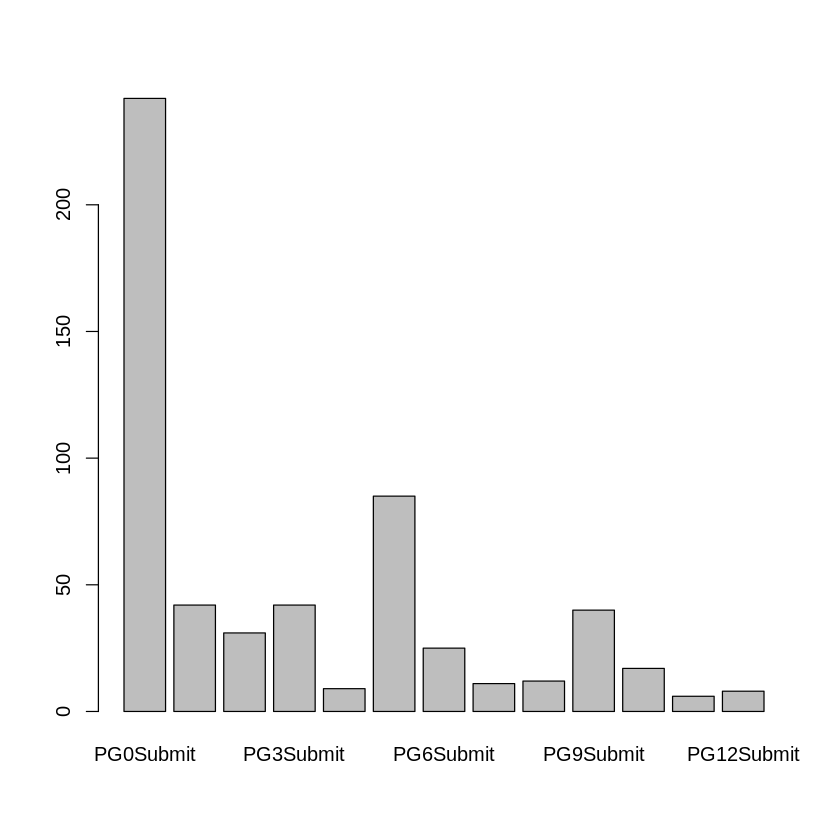

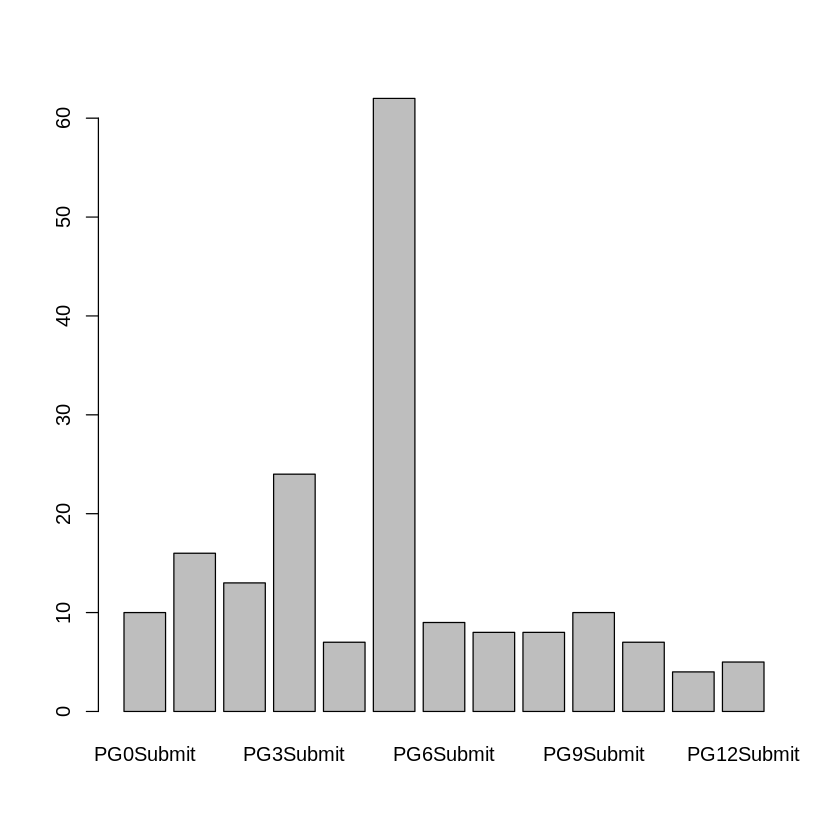

In [21]:
#Q2-Q3
submitted_time <- na.omit(select(completed_responses, contains('Submit')))
#summary(submitted_time)

mean_s_time <- round(apply(submitted_time, 2, mean))
print("Average time: ")
print(mean_s_time)
barplot(mean_s_time)

median_s_time <- apply(submitted_time, 2, median)
print("Median time: ")
print(median_s_time)
barplot(median_s_time)

In [22]:
#Q4
criteria_rank = select(completed_responses, starts_with('PG5'), -ends_with('Time'), -ends_with('Order'), -ends_with('Submit')) 
summary(criteria_rank)

           PG5_1RRPQ             PG5_2BNUI              PG5_3HDS  
                :335                  :381                  :225  
 Essential      : 59   Essential      :  3   Essential      :103  
 High Priority  :102   High Priority  : 25   High Priority  :199  
 Low Priority   : 85   Low Priority   :120   Low Priority   : 68  
 Medium Priority:130   Medium Priority: 91   Medium Priority:161  
 Not a Priority : 94   Not a Priority :185   Not a Priority : 49  
            PG5_4VGP              PG5_5PHR             PG5_6SSYOP 
                :311                  :213                  :310  
 Essential      : 22   Essential      : 79   Essential      : 61  
 High Priority  :109   High Priority  :247   High Priority  :136  
 Low Priority   : 87   Low Priority   : 63   Low Priority   : 83  
 Medium Priority:162   Medium Priority:160   Medium Priority:109  
 Not a Priority :114   Not a Priority : 43   Not a Priority :106  
           PG5_7NDYP              PG5_8CP               PG5_9F

    18 - 24     25 - 34     35 - 44     45 - 54     55 - 64 65 and over 
         34         338         258          89          36           8 


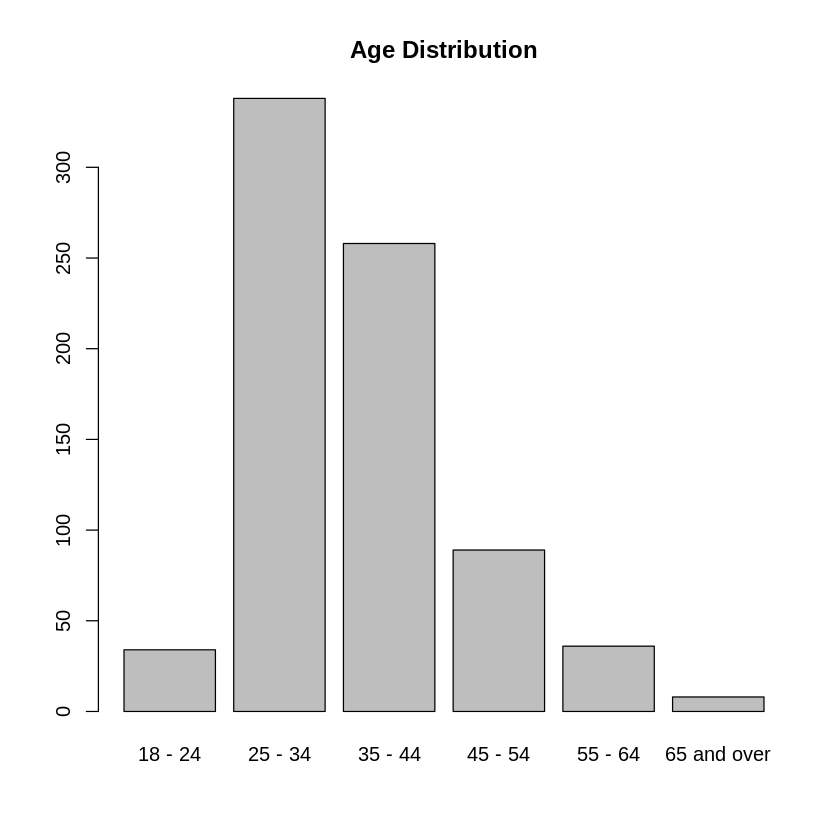

In [23]:
#Q5
age <- select(completed_responses, PG12Resp) %>%
    filter(PG12Resp != '')

age_dist <- factor(age[,])

#summary(completed_responses$PG5_1Order)
#barplot(prop.table(table(age$PG12Resp)))
print(summary(age_dist))
barplot(table(age_dist), main = 'Age Distribution')

# Hypothesis: 
I think the priority is going to be affected by the the response "resolves problems quickly", since that seems to get towards a different idea.

# Approach: 
Descriptive Statistics and what variables to use¶
We will first select variables and run a summary to see some descriptive statistics. We will also see how normalized the distribution is. We will also exclude missing values.

In [34]:
set1 = c('Device' ,'Start','End','PG0Dis','PG0Shown','PG0Submit','PG1PsnUse','PG1Trn',
'PG1Submit' ,'PG2Resp','PG2Submit','PG2Resp.1' ,'PG3Submit' , 
'PG4AllResp','PG4Submit','PG5_1Order','PG5_1Time', 'PG5_8CP','PG5Submit','PG6Resp','PG6Submit','PG7R','PG7C.C..','PG7Java','PG7Python','PG7Javascript',
'PG7Go','PG7C.','PG7Other','PG7Submit','PG8Resp','PG8Submit','PG9Resp','PG9Submit','PG10Resp','PG10Submit',
'PG11Resp','PG11Submit','PG12Resp','PG12Submit')

set2 = c('Device' ,'Start','End','PG0Dis','PG0Shown','PG0Submit','PG1PsnUse','PG1Trn',
'PG1Submit' ,'PG2Resp','PG2Submit','PG2Resp.1' ,'PG3Submit' ,
'PG4AllResp','PG4Submit', 'PG5_10RPA',
'PG5_1RRPQ','PG5_1Time', 'PG5_8CP','PG5Submit','PG6Resp','PG6Submit','PG7R','PG7C.C..','PG7Java','PG7Python','PG7Javascript',
'PG7Go','PG7C.','PG7Other','PG7Submit','PG8Resp','PG8Submit','PG9Resp','PG9Submit','PG10Resp','PG10Submit',
'PG11Resp','PG11Submit','PG12Resp','PG12Submit')

df = dplyr::select(data_complete, set1) %>%
    na.omit()
print(summary(df))

df1 = dplyr::select(data_complete, set2) %>%
    na.omit()
print(summary(df1))
#Desired response model

     Device        Start               End               PG0Dis   
        :  0   Min.   :1.54e+09   Min.   :1.54e+09   Min.   :  0  
 Bot    :  0   1st Qu.:1.54e+09   1st Qu.:1.54e+09   1st Qu.:  0  
 PC     :323   Median :1.54e+09   Median :1.54e+09   Median :  1  
 Phone  : 88   Mean   :1.54e+09   Mean   :1.54e+09   Mean   : 45  
 Tablet :  5   3rd Qu.:1.54e+09   3rd Qu.:1.54e+09   3rd Qu.: 24  
 Unknown:  0   Max.   :1.54e+09   Max.   :1.54e+09   Max.   :168  
                                                                  
    PG0Shown      PG0Submit                                     PG1PsnUse  
 Min.   :   0   Min.   :    2   For personal work and/or research use:290  
 1st Qu.:   0   1st Qu.:    6                                        :120  
 Median : 118   Median :   10   Chapter book                         :  1  
 Mean   : 266   Mean   :   62   Learning how to create a package     :  1  
 3rd Qu.: 463   3rd Qu.:   16   Teaching                             :  1  
 Max.   

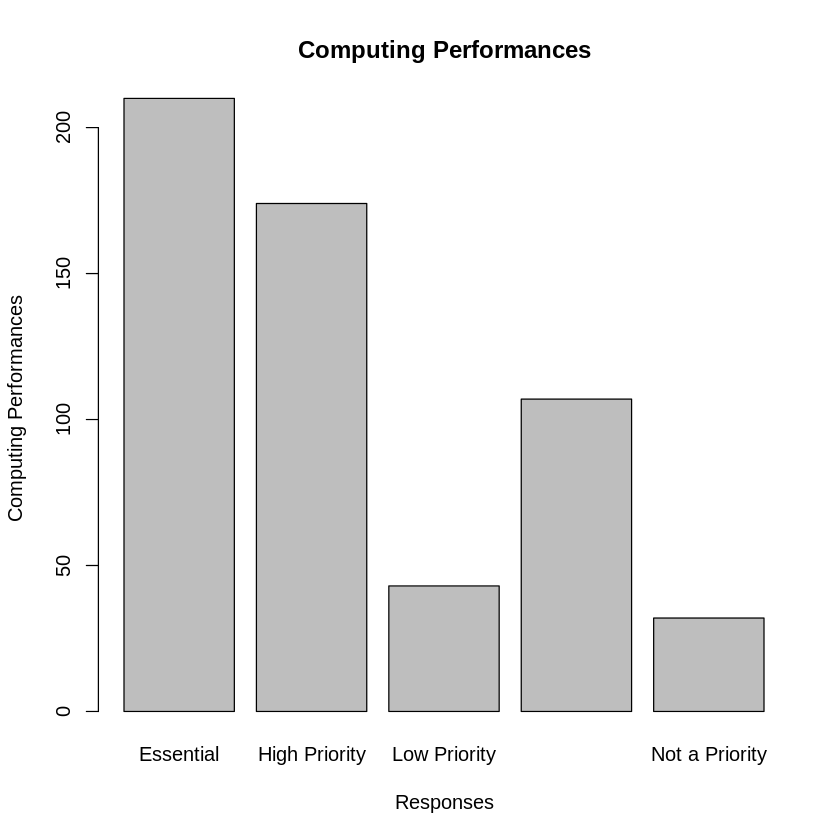

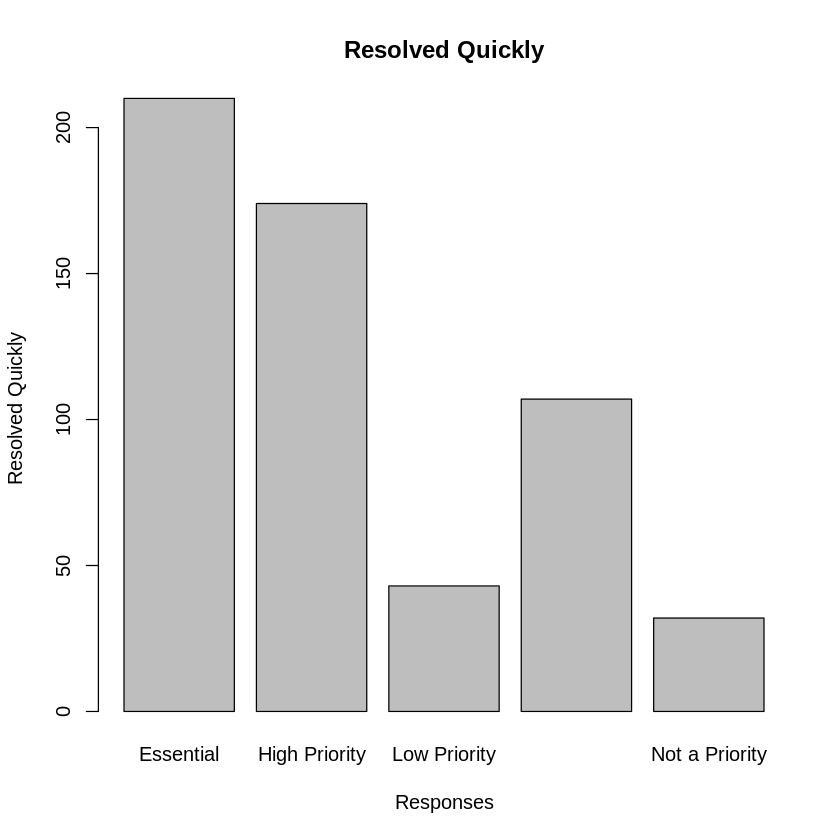

In [47]:
plot(df1$PG5_8CP, main = "Computing Performances", ylab = "Computing Performances", xlab="Responses")
plot(df1$PG5_1RRPQ, main = "Resolved Quickly", ylab = "Resolved Quickly", xlab="Responses")

In [53]:
df1 <- filter(df1, PG5_8CP != '')
summary(df1$PG5_8CP)
df1$PG5_8CP <- factor(df1$PG5_8CP)
summary(df1$PG5_8CP)

Essential   High Priority    Low Priority Medium Priority  Not a Priority 
            210             174              43             107              32

Essential   High Priority    Low Priority Medium Priority  Not a Priority 
            210             174              43             107              32

# Transformation and cleaning:
Get correlations and remove any variables with a correlation of > .7

In [54]:
for(i in colnames(data))
{
    data[,i] <- as.numeric (data[,i]);
}
data <- replace(data, is.na(data), 0)

hiCor <- function(x, level){
  res <- cor(x,method="spearman");
  res1 <- res; res1[res<0] <- -res[res < 0];
  for (i in 1:dim(x)[2]){
    res1[i,i] <- 0;
  }
  sel <- apply(res1,1,max) > level;
  res[sel,sel];
}
hiCor(data,.7)

,Completed,End,PG0Dis,PG0Shown,PG2Resp.1,PG3Submit,PG4Prm9_10,PG4AllResp,PG4Submit,PG5_1RRPQ,...,PG8Resp,PG8Submit,PG9Resp,PG9Submit,PG10Resp,PG10Submit,PG11Resp,PG11Submit,PG12Resp,PG12Submit
Completed,1.0000,0.880,-0.00957,0.01311,0.7359,0.743,0.5312,0.7652,0.7466,0.5703,...,0.8601,0.876,0.8601,0.8730,0.8783,0.8744,0.9081,0.8870,0.8518,0.885
End,0.8796,1.000,0.01515,0.01445,0.6558,0.665,0.4581,0.6643,0.6589,0.4681,...,0.7650,0.779,0.7672,0.7767,0.7727,0.7815,0.7923,0.7983,0.7624,0.796
PG0Dis,-0.0096,0.015,1.00000,0.89092,0.0078,0.024,-0.0093,-0.0013,-0.0270,-0.0058,...,-0.0139,0.014,-0.0022,0.0038,-0.0023,-0.0159,-0.0152,-0.0142,-0.0183,0.016
PG0Shown,0.0131,0.014,0.89092,1.00000,0.0259,0.046,-0.0033,0.0108,-0.0054,0.0073,...,0.0036,0.032,0.0207,0.0215,0.0078,-0.0014,0.0082,-0.0027,-0.0051,0.033
PG2Resp.1,0.7359,0.656,0.00778,0.02585,1.0000,0.729,0.4421,0.6674,0.6761,0.4281,...,0.6437,0.646,0.6600,0.6605,0.6571,0.6501,0.6915,0.6679,0.6479,0.668
PG3Submit,0.7431,0.665,0.02376,0.04597,0.7293,1.000,0.4383,0.6704,0.7515,0.4412,...,0.6479,0.697,0.6384,0.7170,0.6763,0.6923,0.6882,0.6910,0.6361,0.696
PG4Prm9_10,0.5312,0.458,-0.00930,-0.00333,0.4421,0.438,1.0000,0.8805,0.3759,0.3202,...,0.4155,0.414,0.4802,0.4521,0.4275,0.4181,0.4785,0.4332,0.4488,0.444
PG4AllResp,0.7652,0.664,-0.00132,0.01079,0.6674,0.670,0.8805,1.0000,0.6667,0.4527,...,0.6354,0.645,0.6801,0.6722,0.6630,0.6549,0.6942,0.6545,0.6465,0.659
PG4Submit,0.7466,0.659,-0.02698,-0.00543,0.6761,0.752,0.3759,0.6667,1.0000,0.4491,...,0.6742,0.705,0.6338,0.7399,0.7324,0.7516,0.6934,0.7248,0.6395,0.715
PG5_1RRPQ,0.5703,0.468,-0.00579,0.00730,0.4281,0.441,0.3202,0.4527,0.4491,1.0000,...,0.4874,0.498,0.4910,0.5072,0.4857,0.4869,0.5148,0.4964,0.4683,0.505


# Fitting the model
Fitting model, coefficients, etc. detailed in output
Since we are just interpreting coefficients, a linear model is good enough. 

In [55]:
sel = c() 
for (i in 1:dim(data)[2]) if (is.numeric(data[,i])) sel = c(sel, i);
cor(data[,sel], data[,'PG5_8CP'], method="spearman",use="pairwise.complete.obs");
model <- lm(PG5_8CP ~ ., data = data)
summary(model)

Device,-0.1196
Completed,0.7163
Start,-0.0279
End,0.6282
PG0Dis,-0.0154
PG0Shown,-0.0019
PG0Submit,0.2605
PG1PsnUse,0.2881
PG1WdAuth,0.1597
PG1Trn,0.0885
PG1Other,0.0586



Call:
lm(formula = PG5_8CP ~ ., data = data)

Residuals:
   Min     1Q Median     3Q    Max 
-2.698 -0.318 -0.035  0.133  3.423 

Coefficients: (1 not defined because of singularities)
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)   -2.68e+02   1.02e+02   -2.63  0.00863 ** 
Device        -5.16e-02   4.69e-02   -1.10  0.27186    
Completed      2.68e+02   1.02e+02    2.63  0.00860 ** 
Start         -1.74e-07   6.61e-08   -2.63  0.00863 ** 
End           -1.74e-07   6.62e-08   -2.63  0.00875 ** 
PG0Dis         2.85e-04   4.65e-04    0.61  0.54024    
PG0Shown      -1.37e-04   1.05e-04   -1.31  0.18927    
PG0Submit     -7.39e-06   6.76e-06   -1.09  0.27420    
PG1PsnUse      1.53e-02   2.10e-02    0.73  0.46610    
PG1WdAuth      3.48e-02   3.34e-02    1.04  0.29818    
PG1Trn        -6.24e-02   7.52e-02   -0.83  0.40685    
PG1Other       6.71e-03   3.20e-03    2.10  0.03581 *  
PG1Submit     -1.07e-04   1.01e-04   -1.06  0.28713    
PG2Resp        3.18e-03   2.86

# Explanation and interpretation
It turns out my hypothesis was incorrect. To determine this, I checked the correlation between my response variable and my hypothesized explanatory variable. I then fitted to a linear model to determine the p-values of all explanatory variables. The p-value for PG5_1RRPQ (the variable I hypothesized would have significant impact) is 0.61318. This has next to no significance, falsifying my hypothesis.

In total, 28 variables had p-values <.05, and thus show significance to the model. All other variables could be removed with little effect. We can also see that see that the model's adjusted R-squared is 0.668, meaning that the model can explain 66.8% of all the variability of the response data. This means our model is a decent predictor, and predicts a good bit better than chance. 